In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.io as sio
from datetime import datetime
from datetime import datetime, timedelta

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules")
from utils import espra, smooth, robust_smooth, fit_psi_params, psi_params
from utils import normalize_matrix, calc_ow, find_directional_radii, axis_ratio


### Numerical Data

In [2]:
ssh_path = '/srv/scratch/z5297792/ESP_Paper_Data/sat_data_copernicus_CCE_2023_1D_3000m.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

z_ssh = ssh_dataset['depth'][:].data
lon_ssh, lat_ssh = ssh_dataset['longitude'][:].data, ssh_dataset['latitude'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh, indexing='ij')
u_ssh, v_ssh = ssh_dataset['uo'][:].data, ssh_dataset['vo'][:].data
u_ssh, v_ssh = np.transpose(u_ssh, axes=(3,2,1,0)), np.transpose(v_ssh, axes=(3,2,1,0)) # LON, LAT, DEPTH, TIME
tim_ssh = ssh_dataset['time'][:].data # Hours Since 1950-01-01

ref_date = pd.Timestamp("1950-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="h")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,:,t], v_ssh[:,:,:,t]
    ut = np.where(np.abs(ut) < 100, ut, np.nan)
    vt = np.where(np.abs(vt) < 100, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}

theta_mean, phi_mean = np.float64(154.3), np.float64(-37.9)
x_ssh = (lon_ssh - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
y_ssh = (lat_ssh - phi_mean) * 111000


In [3]:
df_res = pd.read_pickle("/srv/scratch/z5297792/ESP_Paper_Data/df_res_copernicus_ESPRA.pkl")
df_res


,xc,yc,w,Q,Rc,psi0,A,R,r2_1,Time,...,sq11,sq12,sq22,sRc,sA,sw,spsi0,e,Data,Method
0,-5802.908374,-1563.771988,-0.000037,"[[1.0301643105849614, -0.08332720822216222], [...",79980.309147,59990.937772,-0.000009,50994.258383,0.992436,2023-10-19 00:00:00,...,0.972914,-0.103055,1.041144,80098.789539,-0.000009,-0.000038,60180.789936,1.241643,Numerical,ESPRA
1,-4981.140748,-26.429374,-0.000036,"[[0.9631693575540718, -0.10730452108581083], [...",75125.576156,56043.380999,-0.000010,46377.603892,0.989580,2023-10-19 23:56:15,...,0.947328,-0.107706,1.072288,80080.554030,-0.000009,-0.000038,60283.696228,1.281300,Numerical,ESPRA
2,-8885.799690,-4721.730306,-0.000037,"[[0.9255072352056705, -0.1185051228863016], [-...",83936.309477,62709.667808,-0.000009,54708.334682,0.990015,2023-10-21 00:00:00,...,0.921162,-0.099094,1.103794,80156.703365,-0.000009,-0.000038,60486.545080,1.307049,Numerical,ESPRA
3,-4142.215128,-4567.341615,-0.000038,"[[0.870303241417468, -0.12170574479314025], [-...",75998.475940,57429.600409,-0.000010,46886.419213,0.993006,2023-10-22 00:00:00,...,0.872769,-0.075292,1.162368,80265.114816,-0.000009,-0.000038,60849.096129,1.382050,Numerical,ESPRA
4,-1078.521019,-4746.479963,-0.000038,"[[0.8168376219820783, -0.06486040912522494], [...",79219.673784,59760.000165,-0.000010,50593.667161,0.992719,2023-10-22 23:56:15,...,0.844242,-0.025686,1.200961,80228.768686,-0.000010,-0.000039,61214.660678,1.427824,Numerical,ESPRA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,-297737.567092,156754.359903,-0.000020,"[[0.8470330042814647, 0.00846037253683076], [0...",56563.738000,21192.102138,-0.000007,42245.696889,0.933604,2024-01-31 00:00:00,...,0.964885,-0.016146,1.192523,63795.485490,-0.000006,-0.000024,22604.580815,1.238566,Numerical,ESPRA
105,-298005.530824,156269.898688,-0.000021,"[[0.8973369092907337, 0.2778837355453176], [0....",50567.244950,18844.824309,-0.000007,36286.868478,0.913641,2024-02-01 00:00:00,...,1.266966,0.140124,1.049442,61643.590718,-0.000006,-0.000026,21094.578184,1.361698,Numerical,ESPRA
106,-300565.349212,165500.883450,-0.000022,"[[1.3276634948890262, 0.4330534110361884], [0....",61189.989808,23495.699822,-0.000006,34514.576102,0.947802,2024-02-02 00:00:00,...,1.725450,0.283161,0.819035,59735.710107,-0.000005,-0.000028,19574.024007,2.448521,Numerical,ESPRA
107,-308726.488912,154030.512188,-0.000024,"[[2.4882099130928554, 0.389587848686837], [0.3...",54999.656769,14430.195185,-0.000005,34974.184189,0.941040,2024-02-02 23:56:15,...,1.944483,0.351657,0.728860,58810.331921,-0.000005,-0.000029,18854.510985,3.213555,Numerical,ESPRA


(np.float64(-321973.617001482),
 np.float64(12278.748814644954),
 np.float64(-15105.23355640024),
 np.float64(186971.97888531548))

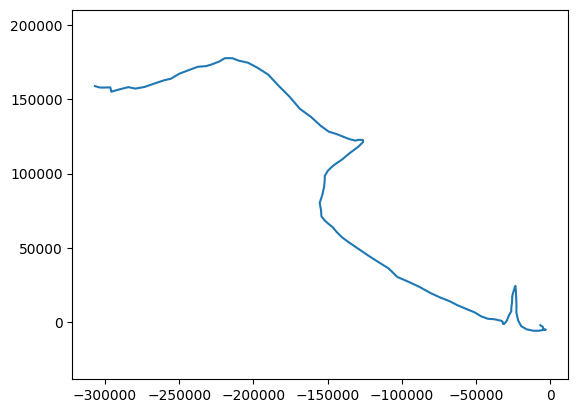

In [4]:
plt.plot(df_res.sxc, df_res.syc)
plt.axis('equal')


In [5]:
rho_core_thresh = 30000.0
dic_k = {}

for surf in df_res.itertuples(index=False):
    ut, vt = dic_ssh_data[surf.Time]['u'], dic_ssh_data[surf.Time]['v']

    xc_pre, yc_pre = float(surf.sxc), float(surf.syc)
    q11_pre, q12_pre, q22_pre = float(surf.sq11), float(surf.sq12), float(surf.sq22)

    rows = [{
        'xc': surf.sxc, 'yc': surf.syc, 'w': surf.sw,
        'q11': surf.sq11, 'q12': surf.sq12, 'q22': surf.sq22,
        'Rc': surf.sRc, 'psi0': surf.spsi0, 'A': surf.sA,
        'r2_1': surf.r2_1, 'r2_2': surf.r2_2, 'Depth': z_ssh[0]
    }]

    for k in range(1, 34):
        utk, vtk = ut[:, :, k], vt[:, :, k]

        dxp, dyp = x_ssh - xc_pre, y_ssh - yc_pre
        rho2_prev = q11_pre*dxp**2 + 2*q12_pre*dxp*dyp + q22_pre*dyp**2
        mask_core = (rho2_prev >= 0.0) & (np.sqrt(rho2_prev) < rho_core_thresh)
        if not np.any(mask_core):
            break

        xi, yi = x_ssh[mask_core], y_ssh[mask_core]
        ui, vi = utk[mask_core], vtk[mask_core]

        xc, yc, w, Q, Rc0, psi00, A0, r2_1, r2_2 = espra(xi, yi, ui, vi, Rc_max=150000, r2_flag=True)

        q11, q12, q22 = Q[0,0], Q[0,1], Q[1,1]

        radii = find_directional_radii(utk, vtk, x_ssh, y_ssh, xc, yc, Q)
        R = float(np.mean([radii['up'], radii['right'], radii['down'], radii['left']]))

        dxc, dyc = x_ssh - xc, y_ssh - yc
        rho2_curr = q11*dxc**2 + 2*q12*dxc*dyc + q22*dyc**2
        rho_outer = max(min(1.75*R, 200000.0), rho_core_thresh)
        mask_outer = (rho2_curr >= 0.0) & (np.sqrt(rho2_curr) < rho_outer)

        if (np.hypot(xc - xc_pre, yc - yc_pre) < 100000.0) and (w < 0.0) and (A0 < 0.0):
            try:
                axi, ayi, aui, avi = x_ssh[mask_outer], y_ssh[mask_outer], utk[mask_outer], vtk[mask_outer]
                df = psi_params(xc, yc, Q, axi, ayi, aui, avi)
                df = df[df.vt <= 0.0]
                Rc, psi0, A, r2_2 = fit_psi_params(df.rho2, df.Qr, df.vt, A0=A0, Rc_max=200000, r2_flag=True)
                if (not np.isfinite(A)) or (A >= 0.0):
                    Rc, psi0, A, r2_2 = np.nan, np.nan, A0, np.nan
            except Exception:
                Rc, psi0, A, r2_2 = np.nan, np.nan, A0, np.nan

            rows.append({'xc': xc, 'yc': yc, 'w': w, 'q11': q11, 'q12': q12, 'q22': q22,
                         'Rc': Rc, 'psi0': psi0, 'A': A, 'R': R, 'r2_1': r2_1, 'r2_2': r2_2, 'Depth': z_ssh[k]})
            xc_pre, yc_pre = xc, yc
            q11_pre, q12_pre, q22_pre = q11, q12, q22
        else:
            break

    df_res_k = pd.DataFrame(rows, columns=['xc','yc','w','q11','q12','q22','Rc','psi0','A','R','r2_1','r2_2','Depth'])

    wdw = 5
    df_res_k['sw']   = smooth(df_res_k.w,    df_res_k.Depth, window=wdw, num=len(df_res_k))
    df_res_k['sq11'] = smooth(df_res_k.q11,  df_res_k.Depth, window=wdw, num=len(df_res_k))
    df_res_k['sq12'] = smooth(df_res_k.q12,  df_res_k.Depth, window=wdw, num=len(df_res_k))
    df_res_k['sq22'] = smooth(df_res_k.q22,  df_res_k.Depth, window=wdw, num=len(df_res_k))
    df_res_k['sRc']  = smooth(df_res_k.Rc,   df_res_k.Depth, window=wdw, num=len(df_res_k))
    df_res_k['spsi0']= smooth(df_res_k.psi0, df_res_k.Depth, window=wdw, num=len(df_res_k))
    df_res_k['sA']   = smooth(df_res_k.A,    df_res_k.Depth, window=wdw, num=len(df_res_k))

    df_res_k['e'] = axis_ratio(df_res_k)
    dic_k[surf.Time] = df_res_k


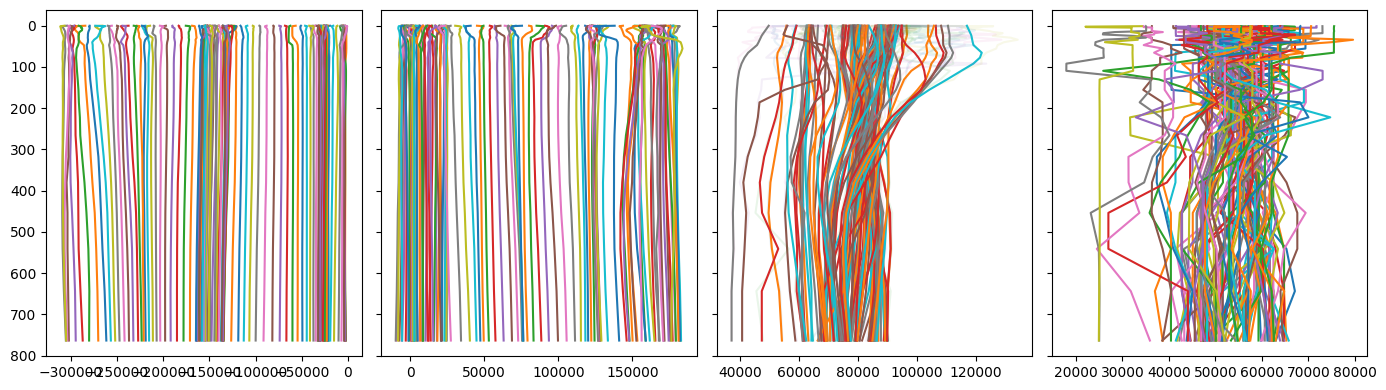

In [6]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(14,4))
for t_idx in range(len(dic_k)):
    time = list(dic_k.keys())[t_idx]
    df = dic_k[time]
    axs[0].plot(df.xc, df.Depth)
    axs[1].plot(df.yc, df.Depth)
    axs[2].plot(df.Rc, df.Depth, alpha=.1)
    axs[2].plot(df.sRc, df.Depth)
    axs[3].plot(df.R, df.Depth)
axs[0].invert_yaxis()
plt.tight_layout()
    

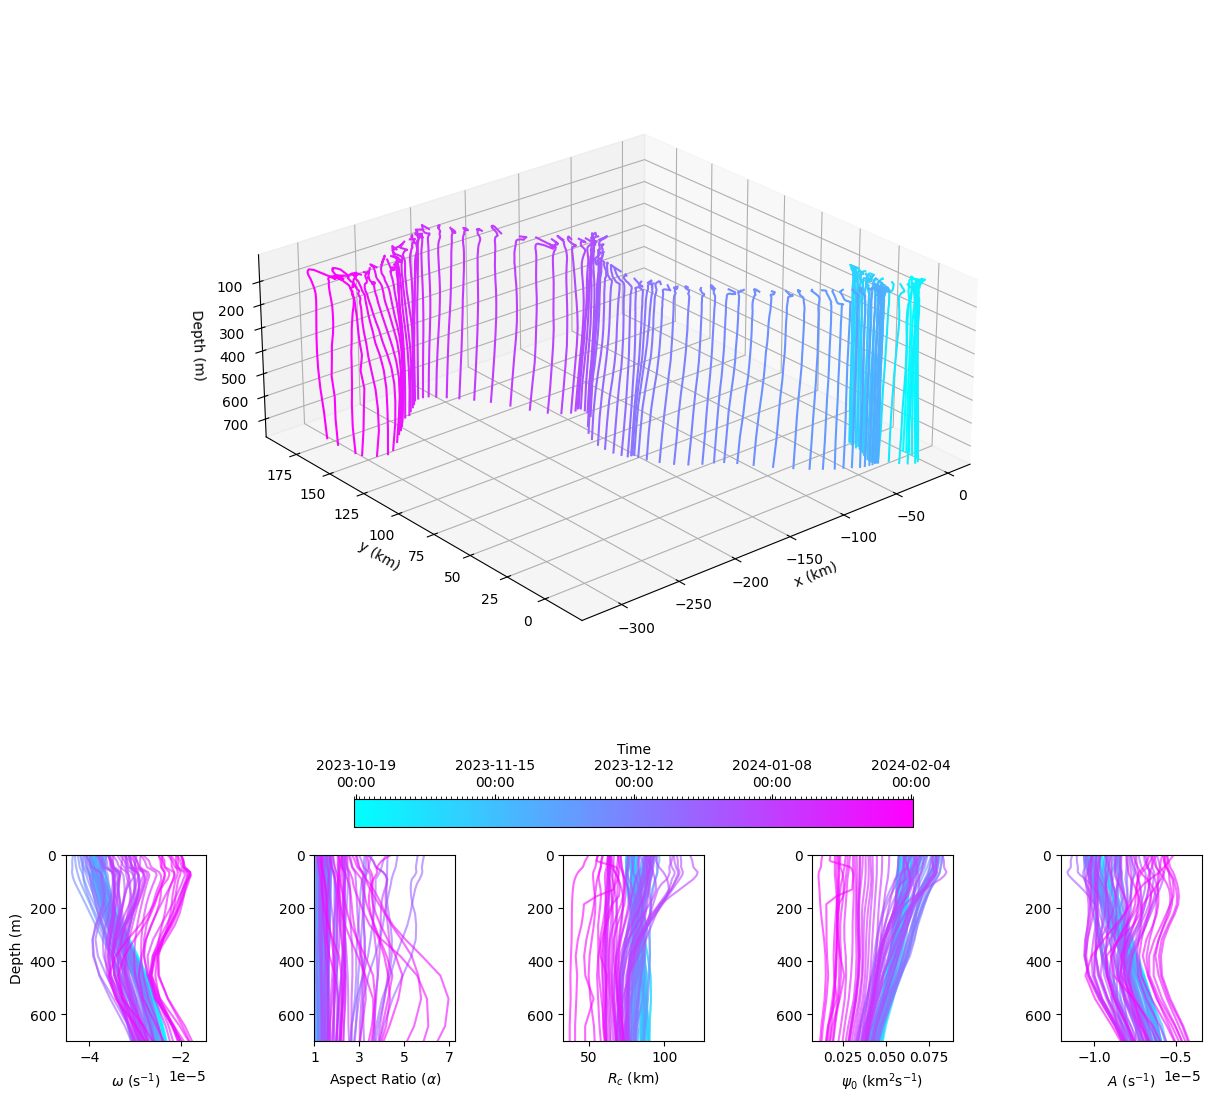

In [7]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.dates as mdates

# === PREP TIME + COLORMAP ===
dt = pd.to_datetime(list(dic_k.keys()), utc=True).tz_localize(None)
dt = pd.to_datetime(sorted(dt))
t = mdates.date2num(dt.to_pydatetime())
n = len(t)

if n > 1:
    mids = (t[:-1] + t[1:]) / 2
    bounds = np.concatenate(([t[0] - (t[1]-t[0])/2], mids, [t[-1] + (t[-1]-t[-2])/2]))
else:
    bounds = np.array([t[0]-0.5, t[0]+0.5])

cmap = mpl.colors.ListedColormap(mpl.cm.cool(np.linspace(0, 1, n)))
norm = mpl.colors.BoundaryNorm(bounds, n)


# === ONE FIGURE, GRID LAYOUT ===
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(2, 1, height_ratios=[2, 1])  # 2 rows: top=3D, bottom=5 subplots


# === 3D AXIS ON TOP ===
ax3d = fig.add_subplot(gs[0], projection='3d')

for time, df in dic_k.items():
    ti = mdates.date2num(pd.to_datetime(time, utc=True).tz_localize(None).to_pydatetime())
    ax3d.plot(df.xc/1e3, df.yc/1e3, df.Depth, color=cmap(norm(ti)))

ax3d.view_init(elev=25, azim=230)
ax3d.set_xlabel('x (km)')
ax3d.set_ylabel('y (km)')
ax3d.set_zlabel('Depth (m)')
ax3d.invert_zaxis()
# ax3d.set_box_aspect((.1, .1, .03))
ax3d.set_box_aspect((1, 1, 0.4))  # (x, y, z) ratios


# === 2D PARAMETER–DEPTH AXES ON BOTTOM (same colors) ===
axs = []
inner = gs[1].subgridspec(1, 5, wspace=0.3)

names = [("sw", r'$\omega$ (s$^{-1}$)'),
         ("e", r'Aspect Ratio ($\alpha$)'),
         ("sRc", r'$R_c$ (km)'),
         ("spsi0", r'$\psi_0$ (km$^2$s$^{-1}$)'),
         ("sA", r'$A$ (s$^{-1}$)')]

alpha = 0.6

for i, (field, label) in enumerate(names):
    ax = fig.add_subplot(inner[i])
    axs.append(ax)

    for time, df in dic_k.items():
        ti = mdates.date2num(pd.to_datetime(time, utc=True).tz_localize(None).to_pydatetime())
        c = cmap(norm(ti))

        y = df.Depth
        if field == "sRc":
            ax.plot(df[field]/1e3, y, color=c, alpha=alpha)
        elif field == "spsi0":
            ax.plot(df[field]/1e6, y, color=c, alpha=alpha)
        else:
            ax.plot(df[field], y, color=c, alpha=alpha)

    if field == 'e':
        ax.set_xticks([1, 3, 5, 7])
        ax.set_xlim(1, None)

    ax.set_xlabel(label)
    ax.invert_yaxis()
    ax.set_ylim(700, 0)

axs[0].set_ylabel("Depth (m)")

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(t)

cbar = fig.colorbar(
    sm, ax=axs + [ax3d], location='top', orientation='horizontal',
    boundaries=bounds, spacing='proportional', pad=0.12
)
cbar.set_label("Time")

tick_positions = np.linspace(t.min(), t.max(), 5)
tick_labels = [mdates.num2date(x).strftime('%Y-%m-%d\n%H:%M') for x in tick_positions]

cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)  

# plt.tight_layout()
plt.show()


In [8]:
X, Y = x_ssh, y_ssh

U = np.zeros((X.shape[0], X.shape[1], len(z_ssh), len(df_res)))
V = np.zeros((X.shape[0], X.shape[1], len(z_ssh), len(df_res)))
OW = np.zeros((X.shape[0], X.shape[1], len(z_ssh), len(df_res)))

for t_idx in range(len(dic_k)):
    time = list(dic_k.keys())[t_idx]
    df = dic_k[time]

    for k in range(len(df)):
        data = df.iloc[k]
        dx, dy = x_ssh - data.xc, y_ssh - data.yc
        rho2 = data.sq11*dx**2 + 2*data.sq12*dx*dy + data.sq22*dy**2
    
        U[:,:,k,t_idx] = - data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq12*dx + 2*data.sq22*dy )
        V[:,:,k,t_idx] =   data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq11*dx + 2*data.sq12*dy ) 

        OW[:,:,k,t_idx] = calc_ow(U[:,:,k,t_idx].T, V[:,:,k,t_idx].T, X[1,0] - X[0,0], Y[0,1] - Y[0,0]).T
    OW[:,:,:,t_idx] = normalize_matrix(OW[:,:,:,t_idx])


In [9]:
import pickle
df_res_sadcp = pd.read_pickle("/srv/scratch/z5297792/ESP_Paper_Data/df_res_sadcp_ESPRA.pkl")


In [24]:
def quad_solver(xc, yc, q11, q12, q22, Rc, y0):

    a = q11
    b = -2*q11*xc + 2*q12*(y0-yc)
    c = q11*xc**2 - 2*q12*xc*(y0-yc) + q22*(y0-yc)**2 - Rc**2/2

    root1 = (-b-np.sqrt(b**2-4*a*c))/(2*a)
    root2 = (-b+np.sqrt(b**2-4*a*c))/(2*a)
    return root1, root2 
    

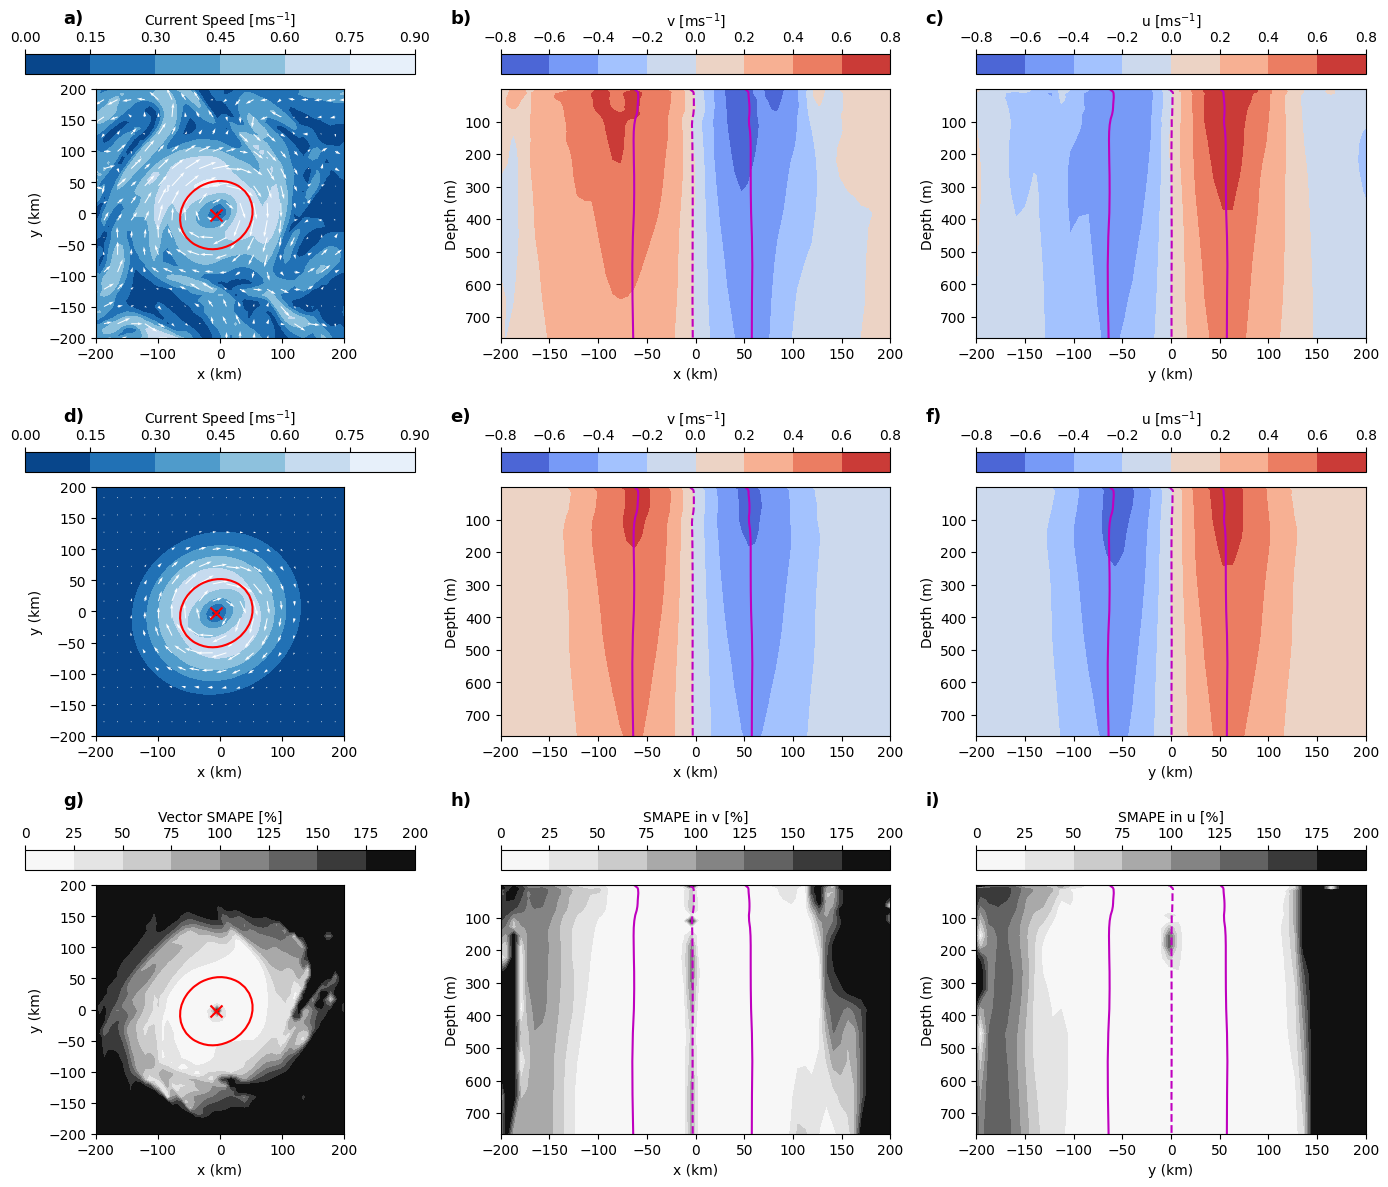

In [26]:
t_sadcp = pd.Timestamp('2023-10-19 18:00:00')
closest = min(df_res.Time, key=lambda tt: abs(tt - t_sadcp))
t_idx = df_res[df_res.Time == closest].index[0]

df_top = dic_k[closest]
surf = df_top.iloc[0]

xc_surf, yc_surf = df_res.loc[t_idx, ['xc','yc']]
ic_surf = np.argmin(np.abs(x_ssh[:,0] - xc_surf))
jc_surf = np.argmin(np.abs(y_ssh[0,:] - yc_surf))
z_lvl_max = 34

u_s, v_s = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']

x1d = x_ssh[:,0]/1e3
y1d = y_ssh[0,:]/1e3
xlim = (-200, 200)
ylim = (-200, 200)
ix = (x1d >= xlim[0]-10) & (x1d <= xlim[1]+10)
iy = (y1d >= ylim[0]-10) & (y1d <= ylim[1]+10)
X = (x_ssh[ix][:,iy])/1e3
Y = (y_ssh[ix][:,iy])/1e3

fig, axs = plt.subplots(3, 3, figsize=(14,12))
labels = ['a)','b)','c)','d)','e)','f)']

spac = 3

# --- Top row (SSH-derived) ---
ax = axs[0,0]
S0 = np.hypot(u_s[ix][:,iy,0], v_s[ix][:,iy,0])
c0 = ax.contourf(X, Y, S0, cmap='Blues_r')
ax.quiver(
    X[::spac, ::spac],
    Y[::spac, ::spac],
    u_s[ix][:, iy, 0][::spac, ::spac],
    v_s[ix][:, iy, 0][::spac, ::spac],
    color='w', width=.004, scale=10
)
dx, dy = x_ssh/1e3 - surf.xc/1e3, y_ssh/1e3 - surf.yc/1e3
rho2 = surf.q11*dx**2 + 2*surf.q12*dx*dy + surf.q22*dy**2
ax.contour(x_ssh/1e3, y_ssh/1e3, rho2, levels=[(surf.Rc/1e3)**2/2], colors='r', linestyles='-')
ax.scatter(surf.xc/1e3, surf.yc/1e3, c='r', marker='x', s=75)
fig.colorbar(c0, ax=ax, location='top').set_label(r'Current Speed [ms$^{-1}$]')
ax.set_xlabel('x (km)'); ax.set_ylabel('y (km)')
ax.set_aspect('equal', adjustable='box'); ax.set_xlim(*xlim); ax.set_ylim(*ylim)
ax.text(-0.13, 1.32, labels[0], transform=ax.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

ax = axs[0,1]
x_sec = x1d[ix]
Vsec = v_s[ix, jc_surf, :z_lvl_max].T
c1 = ax.contourf(x_sec, z_ssh[:z_lvl_max], Vsec, cmap='coolwarm')
ax.plot(df_top.xc/1e3, df_top.Depth, c='m', ls='--')
root1_x, root2_x = [], []
for k in range(len(df_top)):
    df = df_top.iloc[k]
    root1, root2 = quad_solver(df.xc, df.yc,
                                   df.sq11, df.sq12, df.sq22,
                                   df.sRc, y_ssh[0,jc_surf])
    root1_x.append(root1/1e3); root2_x.append(root2/1e3)
ax.plot(root1_x, df_top.Depth, color='m'); ax.plot(root2_x, df_top.Depth, color='m')
ax.invert_yaxis()
fig.colorbar(c1, ax=ax, location='top').set_label(r'v [ms$^{-1}$]')
ax.set_xlabel('x (km)'); ax.set_ylabel('Depth (m)')
ax.set_xlim(*xlim)
ax.text(-0.13, 1.32, labels[1], transform=ax.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

ax = axs[0,2]
y_sec = y1d[iy]
Usec = u_s[ic_surf, iy, :z_lvl_max].T
Usec_cpy = Usec.copy()
Usec_cpy[0,0] = -.6
c2 = ax.contourf(y_sec, z_ssh[:z_lvl_max], Usec_cpy, cmap='coolwarm')
ax.plot(df_top.yc/1e3, df_top.Depth, c='m', ls='--')
root1_y, root2_y = [], []
for k in range(len(df_top)):
    df = df_top.iloc[k]
    root1, root2 = quad_solver(df.xc, df.yc,
                                   df.sq11, df.sq12, df.sq22,
                                   df.sRc, x_ssh[ic_surf,0])
    root1_y.append(root1/1e3); root2_y.append(root2/1e3)
ax.plot(root1_y, df_top.Depth, color='m'); ax.plot(root2_y, df_top.Depth, color='m')
ax.invert_yaxis()
fig.colorbar(c2, ax=ax, location='top').set_label(r'u [ms$^{-1}$]')
ax.set_xlabel('y (km)'); ax.set_ylabel('Depth (m)')
ax.set_xlim(*ylim)
ax.text(-0.13, 1.32, labels[2], transform=ax.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

# --- Bottom row (model U,V at same time) ---
ax = axs[1,0]
S1 = np.hypot(U[ix][:,iy,0,t_idx], V[ix][:,iy,0,t_idx])
S1_cpy = S1.copy()
S1_cpy[0,0] = np.nanmax(S0)
c3 = ax.contourf(X, Y, S1_cpy, cmap='Blues_r')
ax.quiver(
    X[::spac, ::spac],
    Y[::spac, ::spac],
    U[ix][:,iy,0,t_idx][::spac, ::spac],
    V[ix][:,iy,0,t_idx][::spac, ::spac],
    color='w', width=.004, scale=10
)
ax.scatter(surf.xc/1e3, surf.yc/1e3, c='r', marker='x', s=75)
ax.contour(x_ssh/1e3, y_ssh/1e3, rho2, levels=[(surf.Rc/1e3)**2/2], colors='r', linestyles='-')
fig.colorbar(c3, ax=ax, location='top').set_label(r'Current Speed [ms$^{-1}$]')
ax.set_xlabel('x (km)'); ax.set_ylabel('y (km)')
ax.set_aspect('equal', adjustable='box'); ax.set_xlim(*xlim); ax.set_ylim(*ylim)
ax.text(-0.13, 1.32, labels[3], transform=ax.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

ax = axs[1,1]
c4 = ax.contourf(x1d, z_ssh[:z_lvl_max], V[:, jc_surf, :z_lvl_max, t_idx].T, cmap='coolwarm')
ax.plot(df_top.xc/1e3, df_top.Depth, c='m', ls='--')
ax.plot(root1_x, df_top.Depth, color='m'); ax.plot(root2_x, df_top.Depth, color='m')
ax.invert_yaxis()
fig.colorbar(c4, ax=ax, location='top').set_label(r'v [ms$^{-1}$]')
ax.set_xlabel('x (km)'); ax.set_ylabel('Depth (m)')
ax.set_xlim(*xlim)
ax.text(-0.13, 1.32, labels[4], transform=ax.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

ax = axs[1,2]
c5 = ax.contourf(y1d, z_ssh[:z_lvl_max], U[ic_surf, :, :z_lvl_max, t_idx].T, cmap='coolwarm')
ax.plot(df_top.yc/1e3, df_top.Depth, c='m', ls='--')
ax.plot(root1_y, df_top.Depth, color='m'); ax.plot(root2_y, df_top.Depth, color='m')
ax.invert_yaxis()
fig.colorbar(c5, ax=ax, location='top').set_label(r'u [ms$^{-1}$]')
ax.set_xlabel('y (km)'); ax.set_ylabel('Depth (m)')
ax.set_xlim(*ylim)
ax.text(-0.13, 1.32, labels[5], transform=ax.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

eps = 1e-6
# --- Third row: SMAPE (bounded 0–200%) ---
ax = axs[2,0]
u_obs = u_s[ix][:,iy,0]; v_obs = v_s[ix][:,iy,0]
u_mod = U[ix][:,iy,0,t_idx]; v_mod = V[ix][:,iy,0,t_idx]
eps = 1e-6
E   = np.hypot(u_mod - u_obs, v_mod - v_obs)
M   = 0.5*(np.hypot(u_obs, v_obs) + np.hypot(u_mod, v_mod)) + eps
SMV = 100.0 * E / M
c6 = ax.contourf(X, Y, SMV, cmap='Greys', levels=np.linspace(0, 200, 9))
fig.colorbar(c6, ax=ax, location='top').set_label(r'Vector SMAPE [%]')
ax.scatter(surf.xc/1e3, surf.yc/1e3, c='r', marker='x', s=75)
ax.contour(x_ssh/1e3, y_ssh/1e3, rho2, levels=[(surf.Rc/1e3)**2/2], colors='r', linestyles='-')
ax.set_xlabel('x (km)'); ax.set_ylabel('y (km)')
ax.set_aspect('equal', adjustable='box'); ax.set_xlim(*xlim); ax.set_ylim(*ylim)
ax.text(-0.13, 1.32, 'g)', transform=ax.transAxes, fontsize=13, fontweight='bold')

ax = axs[2,1]
obs_v = v_s[:, jc_surf, :z_lvl_max].T
mod_v = V[:, jc_surf, :z_lvl_max, t_idx].T
SM1 = 100.0 * np.abs(mod_v - obs_v) / (0.5*(np.abs(mod_v) + np.abs(obs_v)) + eps)
c7 = ax.contourf(x1d, z_ssh[:z_lvl_max], SM1, cmap='Greys', levels=np.linspace(0, 200, 9))
fig.colorbar(c7, ax=ax, location='top').set_label(r'SMAPE in v [%]')
ax.plot(df_top.xc/1e3, df_top.Depth, c='m', ls='--')
ax.plot(root1_x, df_top.Depth, color='m'); ax.plot(root2_x, df_top.Depth, color='m')
ax.invert_yaxis()
ax.set_xlabel('x (km)'); ax.set_ylabel('Depth (m)')
ax.set_xlim(*xlim)
ax.text(-0.13, 1.32, 'h)', transform=ax.transAxes, fontsize=13, fontweight='bold')

ax = axs[2,2]
obs_u = u_s[ic_surf, :, :z_lvl_max].T
mod_u = U[ic_surf, :, :z_lvl_max, t_idx].T
SM2 = 100.0 * np.abs(mod_u - obs_u) / (0.5*(np.abs(mod_u) + np.abs(obs_u)) + eps)
c8 = ax.contourf(y1d, z_ssh[:z_lvl_max], SM2, cmap='Greys', levels=np.linspace(0, 200, 9))
fig.colorbar(c8, ax=ax, location='top').set_label(r'SMAPE in u [%]')
ax.plot(df_top.yc/1e3, df_top.Depth, c='m', ls='--')
ax.plot(root1_y, df_top.Depth, color='m'); ax.plot(root2_y, df_top.Depth, color='m')
ax.invert_yaxis()
ax.set_xlabel('y (km)'); ax.set_ylabel('Depth (m)')
ax.set_xlim(*ylim)
ax.text(-0.13, 1.32, 'i)', transform=ax.transAxes, fontsize=13, fontweight='bold')

plt.tight_layout()


(np.float64(-467868.1264979113),
 np.float64(327725.45653936424),
 np.float64(-459725.141143799),
 np.float64(437524.9294281004))

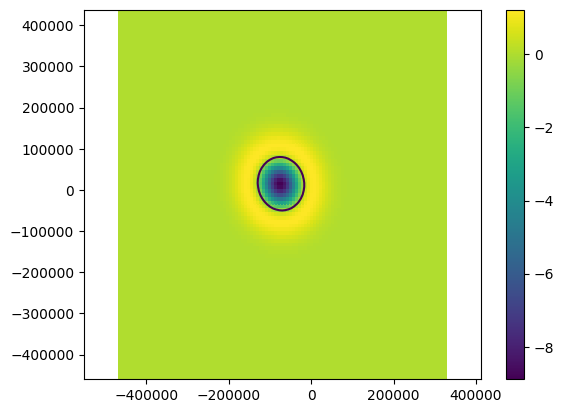

In [13]:
t_idx = 44
k = 32
plt.pcolor(x_ssh, y_ssh, OW[:,:,k,t_idx])
plt.colorbar()
plt.contour(x_ssh, y_ssh, OW[:,:,k,t_idx], levels=[-0.2])
plt.axis('equal')


In [14]:
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# from skimage import measure

# for t_idx in range(len(dic_k)):
#     if t_idx not in [41, 42, 43]:
#         time = list(dic_k.keys())[t_idx]
#         df_t = dic_k[time].copy().sort_values('Depth')
        
#         depth_new = np.arange(df_t['Depth'].min(), df_t['Depth'].max() + 50, 50)
#         idx = pd.Index(np.union1d(df_t['Depth'].to_numpy(), depth_new))
#         df = (df_t.set_index('Depth')
#                   .reindex(idx)
#                   .interpolate(method='index', limit_area='inside')
#                   .loc[depth_new]
#                   .reset_index()
#                   .rename(columns={'index': 'Depth'}))
        
#         z = df.Depth
#         dz = z[1] - z[0]
#         dx, dy = (X[1,0]-X[0,0])/1e3, (Y[0,1]-Y[0,0])/1e3
        
#         verts, faces, normals, values = measure.marching_cubes(OW[:,:,:,t_idx], level=-0.2, spacing=(dx, dy, dz))
#         verts[:,0] += X.min()/1e3
#         verts[:,1] += Y.min()/1e3
#         verts[:,2] += z.min()
        
#         fig = plt.figure(figsize=(10,8))
#         ax = fig.add_subplot(111, projection='3d')
        
#         mesh = Poly3DCollection(verts[faces], alpha=0.4, edgecolor='none', label=r'$\sigma_{\text{OW}}=-0.2$')
#         mesh.set_zsort('min')
#         ax.add_collection3d(mesh)
        
#         ax.set_xlim(X.min()/1e3, X.max()/1e3)
#         ax.set_ylim(Y.min()/1e3, Y.max()/1e3)
#         ax.set_zlim(0, 3000)# z.max())
        
#         ax.plot(df.xc/1e3, df.yc/1e3, df.Depth, color='k', lw=2, label='Center Line')
#         ax.plot(np.nan, np.nan, np.nan, color='r', label=r'Max $v_t$')
        
#         ax.invert_zaxis()
#         ax.set_box_aspect((.1, .1, .09))
#         ax.view_init(elev=25, azim=45)
#         ax.set_xlabel('x (km)')
#         ax.set_ylabel('y (km)')
#         ax.set_zlabel('Depth (m)')
#         # ax.legend()
        
#         fig.suptitle(f'{time}')
#         plt.savefig(f'/srv/scratch/z5297792/ESP_Paper_Data/ESPRA_sat_data/3D_OW_isobath_plots/frame_{t_idx:03d}.png', dpi=300, bbox_inches='tight')
#         plt.close()


In [15]:
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# from skimage import measure

# t_idx = 100

# time = list(dic_k.keys())[t_idx]
# df_t = dic_k[time].copy().sort_values('Depth')

# depth_new = np.arange(df_t['Depth'].min(), df_t['Depth'].max() + 50, 50)
# idx = pd.Index(np.union1d(df_t['Depth'].to_numpy(), depth_new))
# df = (df_t.set_index('Depth')
#           .reindex(idx)
#           .interpolate(method='index', limit_area='inside')
#           .loc[depth_new]
#           .reset_index()
#           .rename(columns={'index': 'Depth'}))

# z = df.Depth
# dz = z[1] - z[0]
# dx, dy = (X[1,0]-X[0,0])/1e3, (Y[0,1]-Y[0,0])/1e3

# verts, faces, normals, values = measure.marching_cubes(OW[:,:,:,t_idx], level=-0.2, spacing=(dx, dy, dz))
# verts[:,0] += X.min()/1e3
# verts[:,1] += Y.min()/1e3
# verts[:,2] += z.min()

# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot(111, projection='3d')

# mesh = Poly3DCollection(verts[faces], alpha=0.4, edgecolor='none', label=r'$\sigma_{\text{OW}}=-0.2$')
# mesh.set_zsort('min')
# ax.add_collection3d(mesh)

# ax.set_xlim(X.min()/1e3, X.max()/1e3)
# ax.set_ylim(Y.min()/1e3, Y.max()/1e3)
# ax.set_zlim(0, 3000)# z.max())

# ax.plot(df.xc/1e3, df.yc/1e3, df.Depth, color='k', lw=2, label='Center Line')
# ax.plot(np.nan, np.nan, np.nan, color='r', label=r'Max $v_t$')

# ax.invert_zaxis()
# ax.set_box_aspect((.1, .1, .09))
# ax.view_init(elev=25, azim=45)
# ax.set_xlabel('x (km)')
# ax.set_ylabel('y (km)')
# ax.set_zlabel('Depth (m)')

